In [2]:
import pygplates
import pandas as pd
import sys
sys.path.append('/Users/Simon/GIT/PlateTectonicTools/')
#import ptt.subduction_convergence as sc
import matplotlib.pyplot as plt

%matplotlib inline
%load_ext autoreload
%autoreload 2

print pygplates.__version__

from reconstruction_classes import *


M2016 = ReconstructionModel('Matthews++2016')
M2016.add_rotation_model('/Applications/GPlates-2.0.0/SampleData/FeatureCollections/Rotations/Matthews_etal_GPC_2016_410-0Ma_GK07.rot')
M2016.add_static_polygons('/Applications/GPlates-2.0.0/SampleData/FeatureCollections/StaticPolygons/Muller_etal_AREPS_2016_StaticPolygons.gpmlz')
M2016.add_dynamic_polygons('/Applications/GPlates-2.0.0/SampleData/FeatureCollections/DynamicPolygons/Matthews_etal_GPC_2016_MesozoicCenozoic_PlateTopologies.gpmlz')
M2016.add_dynamic_polygons('/Applications/GPlates-2.0.0/SampleData/FeatureCollections/DynamicPolygons/Matthews_etal_GPC_2016_Paleozoic_PlateTopologies.gpmlz')
M2016.add_dynamic_polygons('/Applications/GPlates-2.0.0/SampleData/FeatureCollections/DynamicPolygons/Matthews_etal_GPC_2016_TopologyBuildingBlocks.gpmlz')
#a.subduction_convergence(...).plot()
#print a.dynamic_polygons


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
2.0.0.12


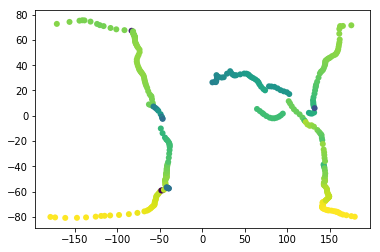

In [3]:
data = M2016.subduction_convergence(120.,threshold_sampling_distance_radians=5.)

data.plot()


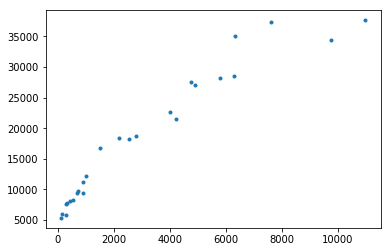

In [4]:
s = M2016.plate_snapshot(90.)

plt.plot(s.plate_areas,s.plate_perimeters,'.')


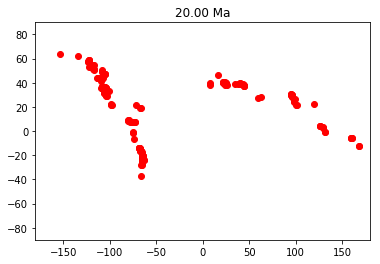

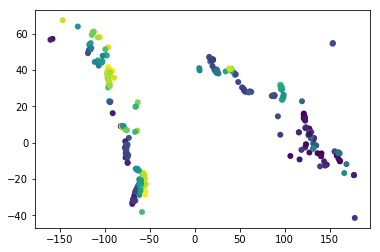

In [5]:

df = pd.read_csv('./Data/ngeo2429-s2.csv',index_col='Deposit number')


t = age_coded_point_dataset(df,'Long.','Lat.','Age (Ma)')

t.assign_reconstruction_model(M2016)

rt = t.plot_reconstructed(20.)


rbt = t.reconstruct_to_time_of_appearance()

plt.figure()
plt.scatter(zip(*rbt)[0],zip(*rbt)[1],c=zip(*rbt)[2],edgecolors='')



/Users/Simon/anaconda/lib/python2.7/site-packages/mpl_toolkits/basemap/__init__.py:1711: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  if limb is not ax.axesPatch:


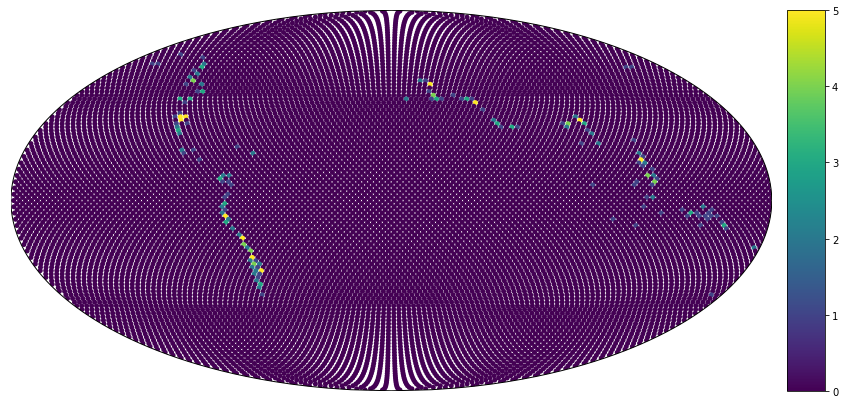

In [6]:
from mpl_toolkits.basemap import Basemap

pos = point_distribution_on_sphere(distribution_type='healpix',N=32)

#print t.point_features

bin_counts = pos.point_feature_heatmap([point.get_geometry() for point in t.point_features])

plt.figure(figsize=(16,7))
m = Basemap(projection='moll',lon_0=0)
x,y = m(pos.longitude,
        pos.latitude)
m.scatter(x,y,c=bin_counts, s=25, edgecolors='', vmax=5)
m.colorbar()
plt.show()



In [19]:
velocity_object = s.velocity_field(velocity_domain_features=[pos.meshnode_feature])

#print type(velocity_object.velocity_magnitude)
for plate_id in s.plate_ids:
    print plate_id,velocity_object.rms_velocity(plate_id)


802 19.5889685152
983 62.1889345308
501 34.6602982307
715 37.9841417544
409 40.770313036
714 21.4372852818
701 37.8454651547
201 28.6687524613
901 45.8389240961
926 133.295178018
528 31.0552164706
801 9.02301206281
529 22.8528705837
307 36.2455611213
308 45.0674061798
806 8.67299750797
787 50.7890688519
301 30.4088743289
530 15.9496077032
304 26.8972738587
224 57.5224791669
985 106.375132513
982 69.2909269469
101 48.5832216925
902 107.031203103
908 92.4245274628


True